In [1]:
from IPython.display import clear_output


import os
from tqdm import tqdm

import numpy as np
import pandas as pd

import PIL
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from customDataLoader import *
from models import *

import sys
sys.path.insert(1, './stylegan2-ada-pytorch')

import dnnlib
import legacy
from torch_utils import misc

In [2]:
import time

In [3]:
#celeba_dir = '../585-Project-nguymi01/data/'

# attr_data = pd.read_csv(os.path.join(celeba_dir, 'list_attr_celeba.csv'))
# part_data = pd.read_csv(os.path.join(celeba_dir, 'list_eval_partition.csv'))

# keys = np.array(list(attr_data.keys()))[1:]

# any_hair_color = np.vstack([(attr_data[_key] == 1).values for _key in keys[[4, 8, 9, 11, 17]]]).T.any(1)
# any_hair_style = np.vstack([(attr_data[_key] == 1).values for _key in keys[[4, 32, 33]]]).T.any(1)
# no_blurry = (attr_data[keys[10]] == -1).values
# no_5o_shadow = (attr_data[keys[0]] == -1).values

# mask = (any_hair_color & any_hair_style & no_blurry & no_5o_shadow & ~((attr_data['Mustache'] == -1) & (attr_data['No_Beard'] == -1)))

In [4]:
device = torch.device('cuda')

class Manipulation(nn.Module):
    def __init__(self, encoder_path=None, copy_encoder_top=True, num_attr=40, device=torch.device('cuda')):
        super().__init__()
                
        #network_pkl = './training-runs/00000--auto1-noaug-resumeffhq256/network-snapshot-000120.pkl'
        network_pkl = './training-runs/00001--auto1-noaug-resumecustom/network-snapshot-000120.pkl'
        print(f'Loading networks from "{network_pkl}"...')
        
        with dnnlib.util.open_url(network_pkl) as fp:
            self.G = legacy.load_network_pkl(fp)['G_ema'].eval().requires_grad_(False) # type: ignore
        
        self.z_dim = self.G.z_dim
        self.num_attr = num_attr
        
        self.encoder = VGG16_Encoder(z_dim=self.z_dim)
        self.encoder_top = EncoderTop()
        
        if encoder_path is not None:
            print(f'Loading encoder from "{encoder_path}"...')
            self.encoder.load_state_dict(torch.load(encoder_path), strict=False)
            if copy_encoder_top:
                self.encoder_top.load_state_dict(self.encoder.top_layers.state_dict().copy())
        #self.encoder = self.encoder.eval().requires_grad_(False).to(self.device)
        self.encoder = self.encoder
        self.encoder_top = self.encoder_top
        
#         self.attr_mapping = nn.Sequential(
#             nn.Linear(self.num_attr, self.num_attr),
#             nn.LayerNorm(self.num_attr)
#             nn.Tanh()
#         )
        
        _ = np.linalg.svd(np.random.normal(size=[self.z_dim]*2))
        _ = _[0] @ _[-1][:, :self.num_attr]
        self.attr_directions = torch.nn.Parameter(torch.from_numpy(_).to(torch.float))
        self.project_attr_directions_to_orth()
        
        _ = np.linalg.svd(np.random.normal(size=[self.z_dim]*2))
        _ = _[0] @ _[-1][:, :self.num_attr]
        self.attr_inverse = torch.nn.Parameter(torch.from_numpy(_).to(torch.float))
    
    def project_attr_directions_to_orth(self):
        with torch.no_grad():
            for name, param in self.named_parameters():
                if 'attr_directions' in name:
                    _ = torch.linalg.svd(param.cpu().detach())
                    _ = _[0] @ torch.eye(*param.shape) @ _[-1]
                    param.copy_(_)

    def forward(self, target_images, target_labels):
        embs_t = self.encoder(target_images)
        
        idnt, attr_r = self.get_idnt_attr_from_images(target_images)
        embs_r = idnt + attr_r
        
        idnt, attr_m = self.manipulation(target_images, target_labels)
        embs_m = idnt + attr_m
        
        return embs_t, embs_r, embs_m
    
    def get_idnt_attr_from_images(self, target_images):
        embs = self.encoder(target_images)
        idnt = self.encoder_top(self.encoder.vgg16(target_images))
        
        idnt_normed = idnt / torch.norm(idnt, dim=1).unsqueeze(1).repeat([1, idnt.shape[-1]])
        projection = (idnt_normed * embs).sum(1).unsqueeze(1).repeat([1, idnt.shape[-1]]) * idnt_normed
        attr = embs - projection
        return idnt, attr
    
    def classifier(self, target_images, return_logit=False):
        _idnt, attr = self.get_idnt_attr_from_images(target_images)
        logit = attr @ self.attr_directions
        
        if return_logit:
            return logit
        else:
            return nn.functional.sigmoid(logit)
    
    def manipulation(self, target_images, target_labels, return_embs=False):
        idnt, attr_r = self.get_idnt_attr_from_images(target_images)
        norm_idnt = torch.norm(idnt, dim=1)
        
        weights = nn.functional.tanh(idnt @ self.attr_inverse) * (2 * target_labels - 1)
        attr = (weights @ self.attr_directions.t()) + 1e-3 * idnt
        
        scale = (attr * idnt).sum(1)  / (norm_idnt * (1 - norm_idnt))
        attr_m = scale.unsqueeze(1) * attr
        
        if return_embs:
            embs = idnt + attr_m
            return embs
        else:
            return idnt, attr_r, attr_m
    
    def synthesis(self, input_embeddings):
        synth_images = self.G.synthesis(
            input_embeddings.unsqueeze(1).repeat([1, self.G.mapping.num_ws, 1]),
            noise_mode='const'
        )
        synth_images = (synth_images + 1) * (255/2)
        return synth_images

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
data_loader = DataLoader(pretrained_embeddings_filename='overfit_sample_embeddings_freshrun.npy')

In [7]:
#encoder_path = f'./training-runs/encoder_synth.sdict'
encoder_path = None
man = Manipulation(encoder_path=encoder_path).to(device)
man.load_state_dict(torch.load('./training-runs/man.sdict'))

Loading networks from "./training-runs/00001--auto1-noaug-resumecustom/network-snapshot-000120.pkl"...


<All keys matched successfully>

In [48]:
test_image_fnames = ['182638.jpg', '182639.jpg', '182640.jpg', '182641.jpg']
test_images = load_image_batch(
    _image_fnames=test_image_fnames, img_resolution=256,
    dataset_path='/projectnb/cs585bp/585-Project-nguymi01/data/img_align_celeba/img_align_celeba/',
    batch_size=16, batch_num=0, randomize=False, seed=0)

test_labels = data_loader.attr_data[data_loader.attr_data.image_id.isin(test_image_fnames)].values[:, 1:-1] == 1

def test(test_images, test_labels,
         test_keys = ['Black_Hair', 'Blond_Hair', 'Straight_Hair', 'Wavy_Hair', 'Male'],
         name=None):
    test_key_inds = np.array([list(data_loader.attr_data.columns[1:-1]).index(key) for key in test_keys],                            )

    test_labels = [test_labels]
    for keyind in test_key_inds:
        temp_labels = test_labels[0].copy()
        temp_labels[:, keyind] = ~temp_labels[:, keyind]
        test_labels.append(temp_labels)

    target_images = torch.tensor(test_images.transpose([0, 3, 1, 2]), device=device).to(torch.float32)
    synth_images_list = []

    for i in range(len(test_labels)):
        target_labels = torch.from_numpy(test_labels[i].astype(np.float32)).to(device)
        idnt, attr_r, attr_m = man.manipulation(target_images, target_labels)
        embs_m = idnt + attr_m
        synth_images_list.append(man.synthesis(embs_m).permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8).cpu().detach().numpy())

    clear_output(wait=True)
    print()
    _images = np.vstack([test_images] + synth_images_list)

    m = test_images.shape[0]
    n = _images.shape[0] // m
    plt.figure(figsize=(20, 20))
    plt.imshow(np.vstack([
        np.hstack([_images[m * i+j] for i in range(n)])
        for j in range(m)
    ]))
    for i, key in enumerate(['Input', 'Reconstruction'] + test_keys):
        plt.text(i * test_images.shape[1] + test_images.shape[1]//2 - 6.5*len(key), -10, key, fontsize=12)
    plt.axis('off')
    if name is None:
        name = 'test.png'
    plt.savefig(name)
    
#test(test_images, test_labels, name='test_pretrain.png')

In [50]:
data_loader.attr_data[data_loader.attr_data.partition==2]

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,partition
182637,182638.jpg,-1,1,-1,1,-1,-1,-1,-1,-1,...,1,-1,1,1,1,-1,-1,-1,-1,2
182638,182639.jpg,-1,-1,-1,-1,-1,-1,-1,1,1,...,-1,-1,1,-1,-1,1,-1,-1,1,2
182639,182640.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,1,-1,1,-1,-1,1,-1,-1,1,2
182640,182641.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,1,-1,-1,1,-1,1,-1,-1,1,2
182641,182642.jpg,-1,-1,-1,-1,-1,-1,-1,-1,1,...,1,-1,-1,-1,-1,-1,-1,-1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202594,202595.jpg,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,1,-1,-1,1,2
202595,202596.jpg,-1,-1,-1,-1,-1,1,1,-1,-1,...,1,1,-1,-1,-1,-1,-1,-1,1,2
202596,202597.jpg,-1,-1,-1,-1,-1,-1,-1,-1,1,...,1,-1,-1,-1,-1,-1,-1,-1,1,2
202597,202598.jpg,-1,1,1,-1,-1,-1,1,-1,1,...,1,-1,1,1,-1,1,-1,-1,1,2


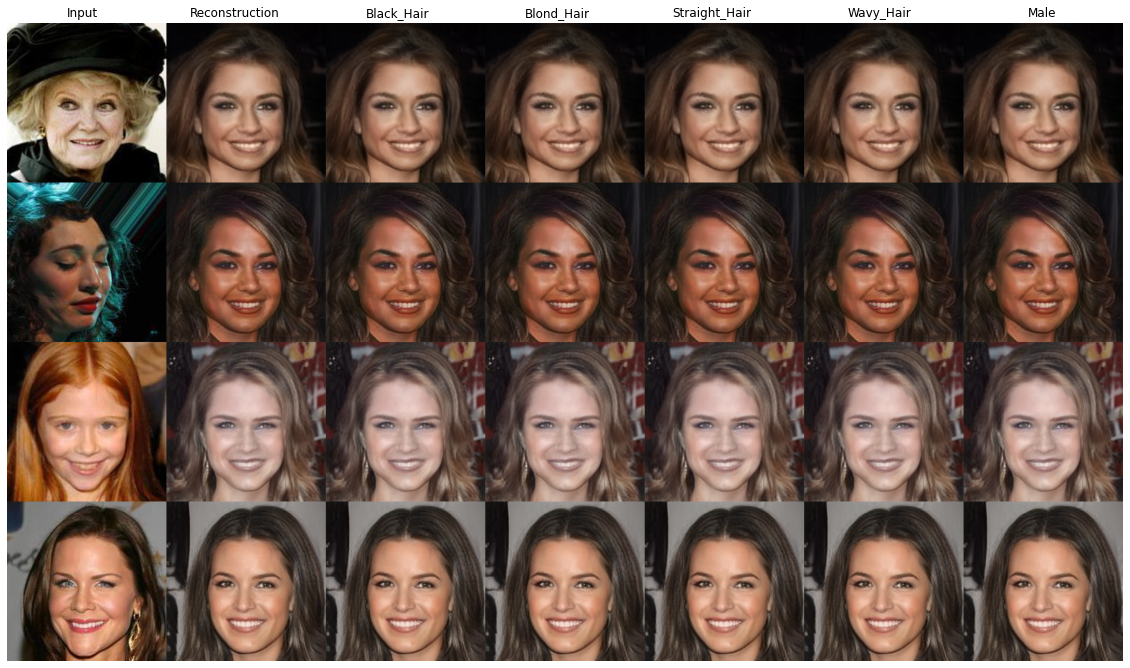

In [49]:
test(test_images, test_labels, name='test_pretrain.png')

In [10]:
torch.cuda.empty_cache()

In [11]:
man = man.train()

In [12]:
initial_learning_rate = 5e-3

emergency_stop = False

#params = [p for p in man.parameters() if p.requires_grad]
params = [p for p in man.encoder_top.parameters() if p.requires_grad]
params+= [man.attr_directions]
optimizer = torch.optim.AdamW(params, betas=(0.9, 0.999), lr=initial_learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9999,#88,
                                                   last_epoch=-1, verbose=True)

pretraining=False

num_epoch=16

data_loader.state['queue'] = None

Adjusting learning rate of group 0 to 5.0000e-03.


In [13]:
batch_size=4

In [25]:
epoch=0

In [ ]:
torch.cuda.empty_cache()
scaler = torch.cuda.amp.GradScaler()

for epoch in tqdm(range(epoch, num_epoch)):
    torch.cuda.empty_cache()
    
    batch_images, batch_labels, batch_embs = data_loader.get_batch(
        batch_size=batch_size,
        refresh=True,
        with_pretrained_embeddings=True
    )
    pbar = tqdm(range(1 + data_loader.state['queue'].shape[0] // batch_size))
    
    for step in pbar:
        torch.cuda.empty_cache()
        loss_dict = {}

        target_images = torch.tensor(batch_images.transpose([0, 3, 1, 2]), device=device).to(torch.float32)
        target_labels = torch.from_numpy(batch_labels.astype(np.float32)).to(device)
        
        if pretraining:
            predic_labels = man.classifier(target_images)
            loss_dict['clsf_loss'] = nn.functional.binary_cross_entropy_with_logits(predic_labels, target_labels)
            
            target_embs = torch.from_numpy(batch_embs).to(device)
            loss_dict['dist_emb_t'] = nn.functional.mse_loss(embs_t, target_embs).sqrt() + nn.functional.l1_loss(embs_t, target_embs)
            loss_dict['dist_emb_r'] = nn.functional.mse_loss(embs_r, target_embs).sqrt() + nn.functional.l1_loss(embs_r, target_embs)
            loss_dict['dist_emb_m'] = nn.functional.mse_loss(embs_m, target_embs).sqrt() + nn.functional.l1_loss(embs_m, target_embs)
        else:
            predic_labels = man.classifier(target_images)
            loss_dict['clsf_loss'] = nn.functional.binary_cross_entropy_with_logits(predic_labels, target_labels)
            
            randinds = torch.randperm(target_labels.size(0))
            modify_labels = target_labels[randinds]
            
            idnt, attr_r, attr_m = man.manipulation(target_images, modify_labels)
            imgs_r, imgs_m = [man.synthesis(idnt + _attr) for _attr in [attr_r, attr_m]]
            predic_labels_m = man.classifier(imgs_m)
            
            loss_dict['clsf_m_loss'] = nn.functional.binary_cross_entropy_with_logits(predic_labels_m, modify_labels)
            loss_dict['dist_img_r'] = (nn.functional.mse_loss(imgs_r, target_images).sqrt() + nn.functional.l1_loss(imgs_r, target_images))/255
            
        
        loss = 0
        logstr = [f'EPOCH{epoch:4d} STEP{step:6d}']
        for key, val in loss_dict.items():
            loss += val
            logstr.append(f'{key}: {val:.3E}')
        logstr = '; '.join(logstr)
        
        clear_output(wait=True)
        pbar.set_description(logstr)
        if loss.isnan():
            print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! NAN loss')
            print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! NAN loss')
            print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! NAN loss')
            emergency_stop = True
            #break ####<=======================*******************************************************************

        optimizer.zero_grad(set_to_none=True)
        scaler.scale(loss).backward()
        nn.utils.clip_grad_value_(params, clip_value=1e3)

        for i in range(len(params)):
            if params[i].grad is not None:
                misc.nan_to_num(params[i].grad, nan=0, posinf=1e3, neginf=-1e3, out=params[i].grad)

        scaler.step(optimizer)
        scaler.update()
        
        scheduler.step()
        man.project_attr_directions_to_orth()
        
        
        batch_images, batch_labels, batch_embs = data_loader.get_batch(
            batch_size=batch_size,
            #refresh=True,
            with_pretrained_embeddings=True
        )
    #break         ####<=======================*******************************************************************
    if emergency_stop:
        break
    clear_output(wait=True)
    

In [27]:
batch_images, batch_labels, batch_embs = data_loader.get_batch(
    batch_size=batch_size,
    refresh=True,
    with_pretrained_embeddings=True
)

...refreshing queue...


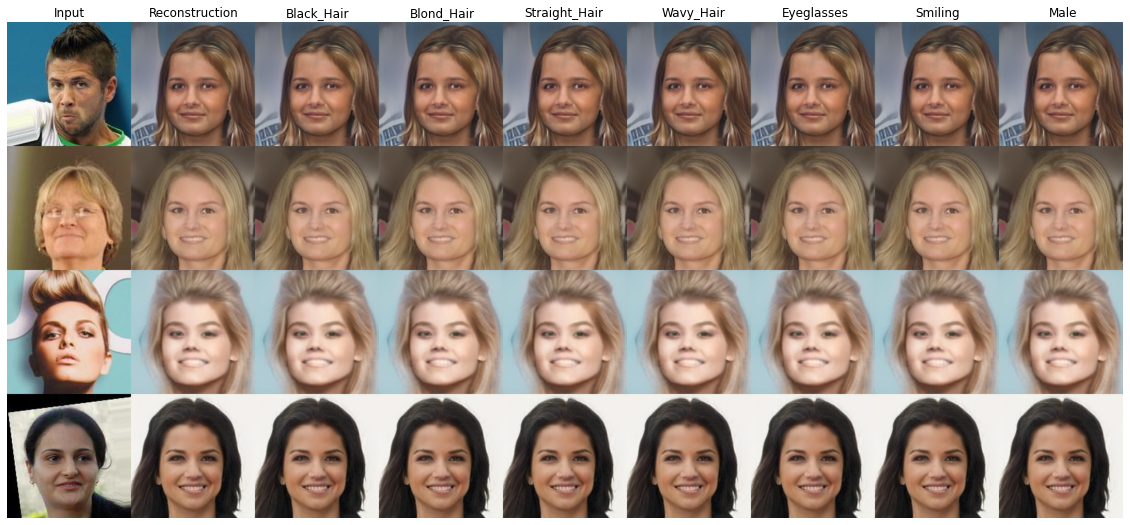

In [29]:
test(batch_images, batch_labels, name='train-w_clsf.png')